In [3]:
import gridstatusio as gs
import gridstatus as g
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime
import requests
import Grid_Status_Functions as gf

****Objectives:****

1. When is peak demand in PJM in December 2022? Time of day? Specific days?

2. How did LMPs change in PJM during December 2022? Did Winter Storm Elliot Affect this?

3. Does the fuel mix change at peak demand?

4. Would virtual power plants be helpful in PJM? When?


<h1><center>US ISOs</center></h1>

<div>
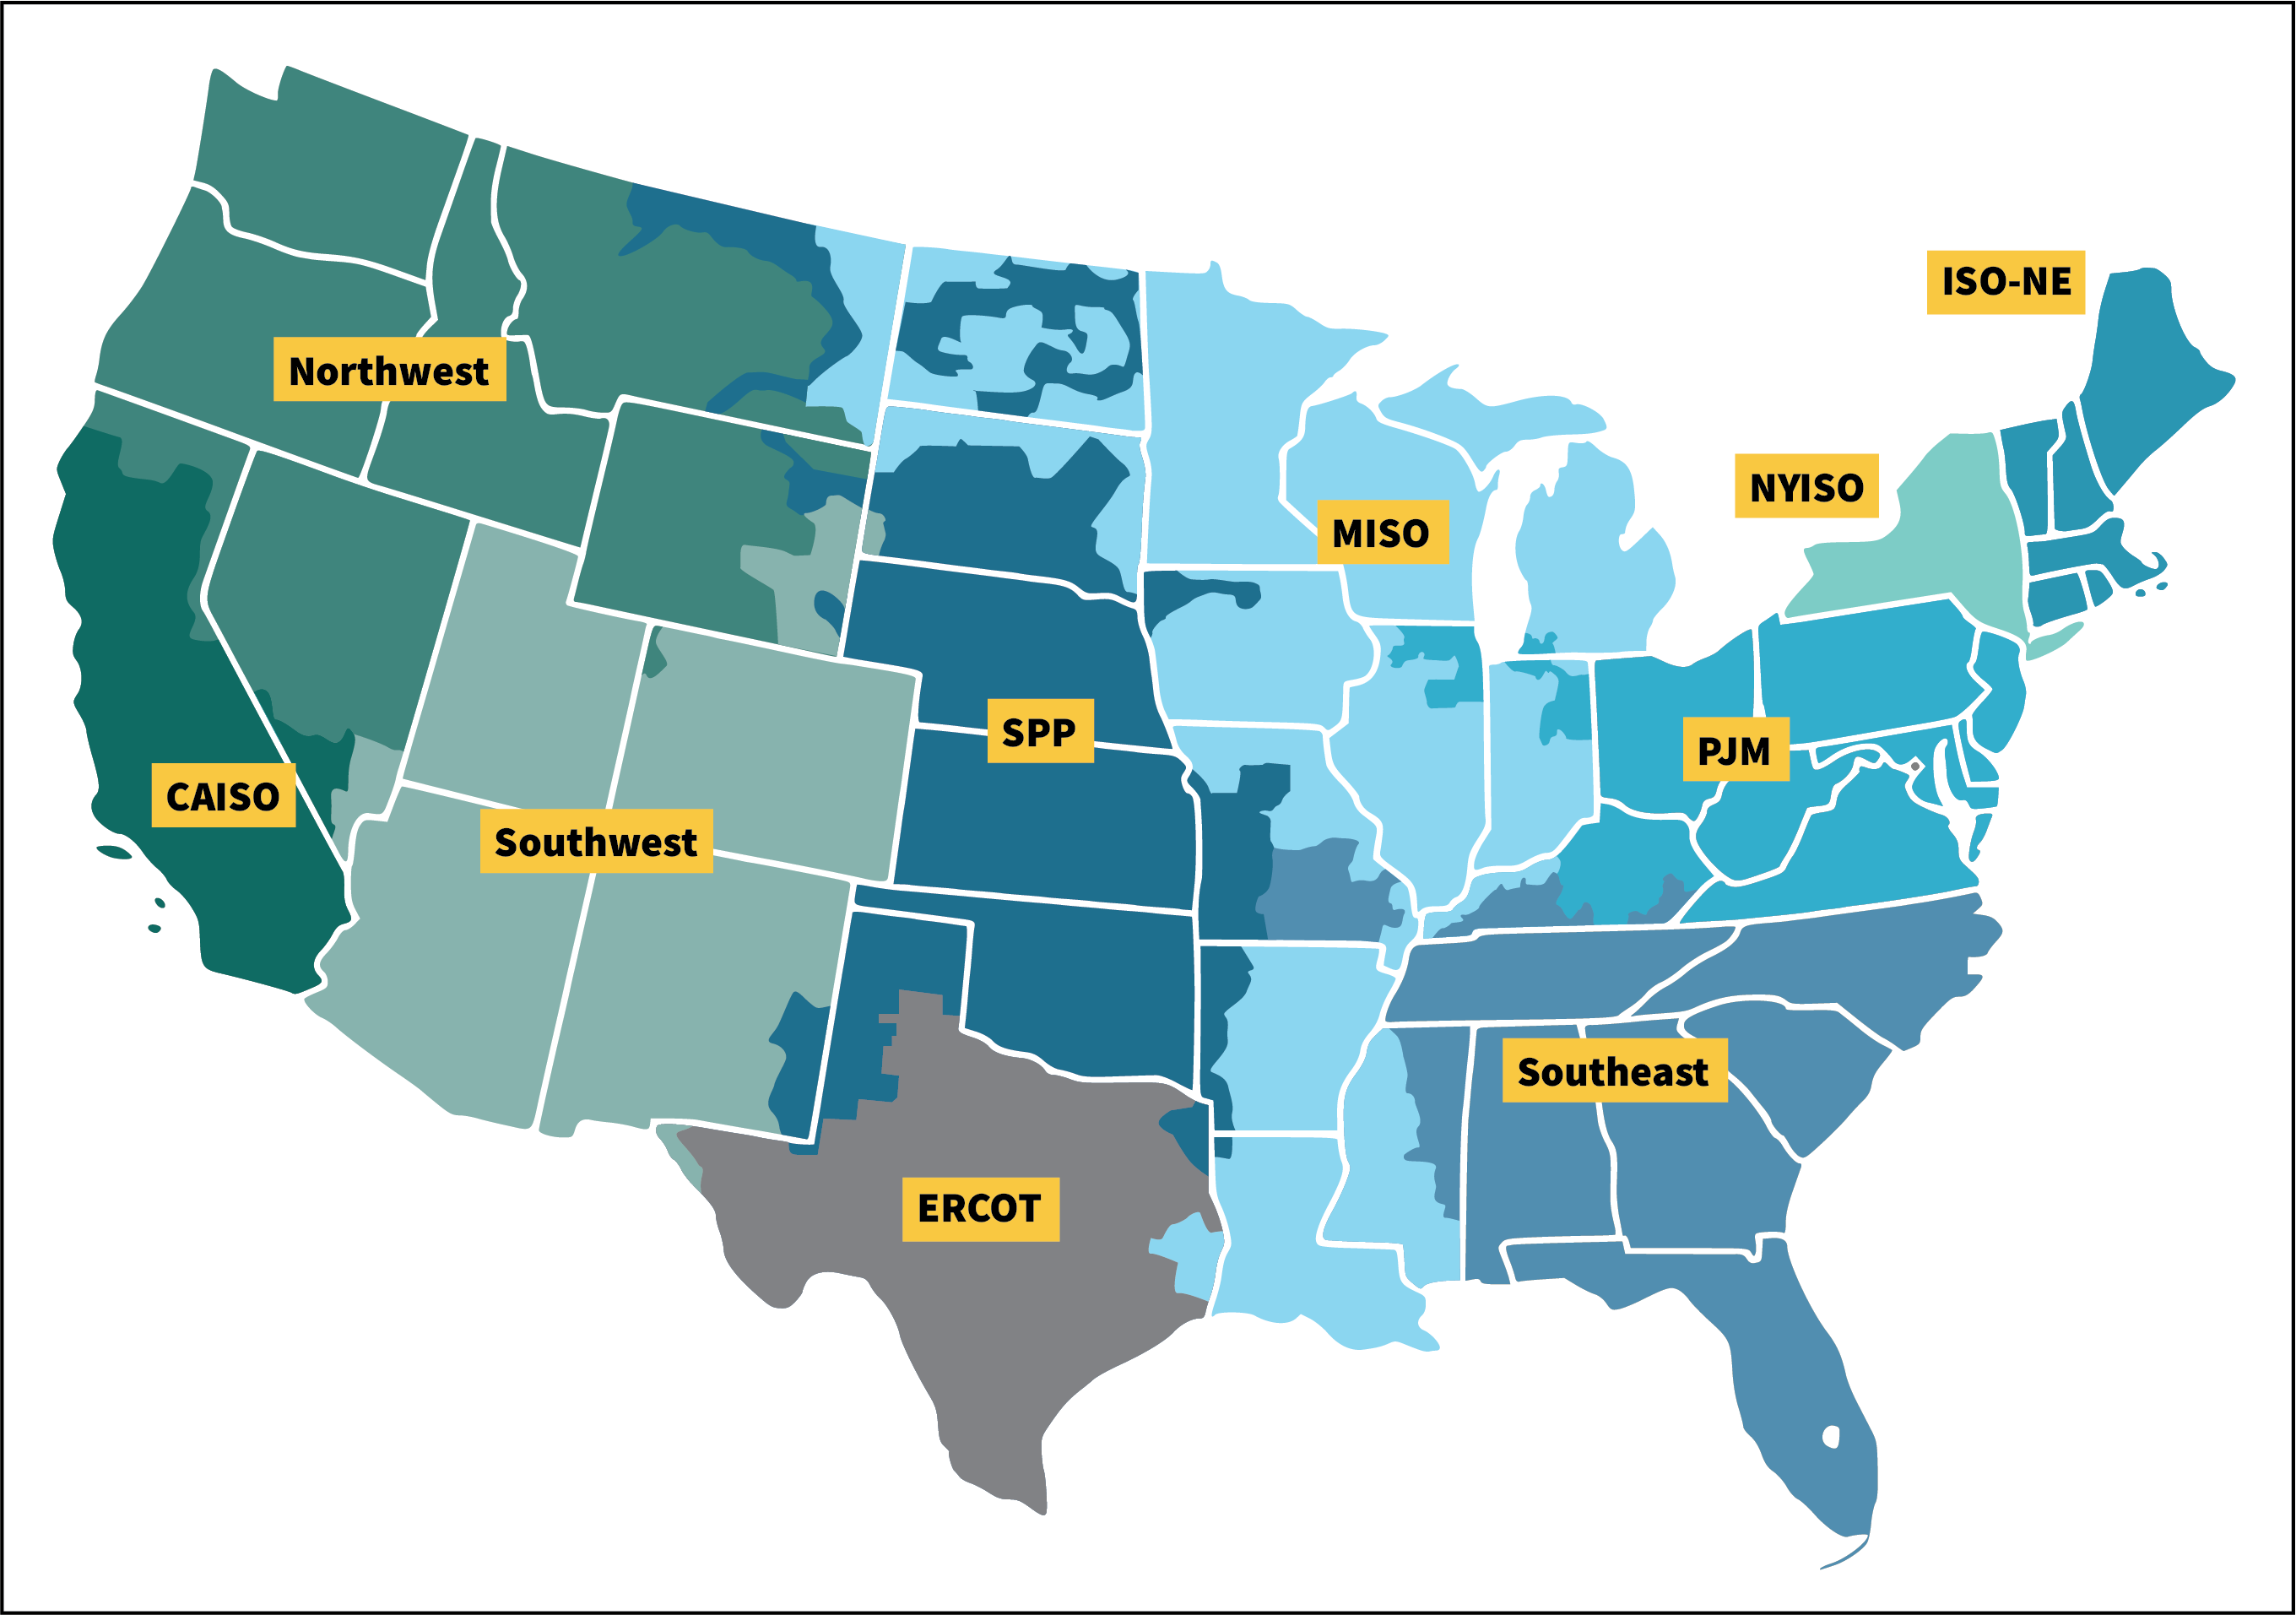
</div>
<div style="text-align: center"> source: https://www.ferc.gov/power-sales-and-markets/rtos-and-isos </div>

In [3]:
gs.api_key  = 'Hd8UWiGA7x6eVg99qOBBH6LUZkTh0ONM1OEeRZPZ'

In [4]:
df_datasets = pd.read_csv('https://data.gridstatus.io/datasets/historical_data_availability/latest.csv')

## Gridstatus datasets available for PJM

In [5]:
df_datasets[df_datasets["iso"].str.contains('pjm')]

,iso,dataset,earliest,latest,num_missing,earliest_no_missing,missing,hidden
46,pjm,daily_load_last_30_days,2023-01-24,2023-03-11,0,2023-01-24,[],True
47,pjm,fuel_mix,2016-01-01,2023-03-11,0,2016-01-01,[],False
48,pjm,fuel_mix_categorized,2016-01-01,2023-03-11,0,2016-01-01,[],False
49,pjm,fuel_mix_clean,2016-01-01,2023-03-11,0,2016-01-01,[],False
50,pjm,interconnection_queue,2023-02-02,2023-03-11,0,2023-02-02,[],False
51,pjm,lmp_day_ahead_hourly_hub,2018-01-01,2023-03-11,0,2018-01-01,[],False
52,pjm,lmp_day_ahead_hourly_interface,2018-01-01,2023-03-11,0,2018-01-01,[],False
53,pjm,lmp_day_ahead_hourly_zone,2018-01-01,2023-03-11,0,2018-01-01,[],False
54,pjm,lmp_real_time_5_min_hub,2022-09-03,2023-03-11,0,2022-09-03,[],False
55,pjm,lmp_real_time_5_min_zone,2022-09-03,2023-03-11,0,2022-09-03,[],False


## GridStatus ISOs

In [6]:
ercot = g.Ercot()
isone = g.ISONE()
caiso = g.CAISO()
pjm = g.PJM()
miso = g.MISO()
spp = g.SPP()
nyiso = g.NYISO()

# Winter Storm Elliot 12/21/2022 - 12/26/2022 

We'll gather load and LMP data from PJM from the month of December 2022 to evaluate when peak demand is and if that changed during the storm. According to poweroutage.com, over x customers were affected in PJM.

## Get data from gridstatus API and save it locally

In [7]:
start = "2022-12-01"
end = "2022-12-31"

In [8]:
#LMP data

pjm_lmp_api = gs.get_dataset(
    dataset="pjm/lmp_real_time_5_min_zone",
    start=start,
    end=end,
)

pjm_lmp_api.reset_index(inplace=True)
pjm_lmp_api.to_parquet('pjm_lmp_dec2022.parquet')

100%|███████████████████████████████████████████| 31/31 [00:51<00:00,  1.66s/it]


In [9]:
#Fuel mix data - substitute for load because of missing load data in PJM for December 2022

pjm_mix_api = gs.get_dataset(
    dataset="pjm/fuel_mix",
    start=start,
    end=end,
)

pjm_mix_api.reset_index(inplace=True)
pjm_mix_api.to_parquet('pjm_mix_dec2022.parquet')

100%|███████████████████████████████████████████| 31/31 [00:19<00:00,  1.61it/s]


## Load local data

In [4]:
lmp_df = pd.read_parquet('pjm_lmp_dec2022.parquet')

In [5]:
gf.basics(lmp_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205344 entries, 0 to 205343
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype                                 
---  ------         --------------   -----                                 
 0   Time           205344 non-null  datetime64[ns, pytz.FixedOffset(-300)]
 1   Market         205344 non-null  object                                
 2   Location       205344 non-null  int64                                 
 3   Location Name  205344 non-null  object                                
 4   Location Type  205344 non-null  object                                
 5   LMP            205344 non-null  float64                               
 6   Energy         205344 non-null  float64                               
 7   Congestion     205344 non-null  float64                               
 8   Loss           205344 non-null  float64                               
dtypes: datetime64[ns, pytz.FixedOffset(-300)](1), flo

,Time,Market,Location,Location Name,Location Type,LMP,Energy,Congestion,Loss
0,2022-12-01 00:00:00-05:00,REAL_TIME_5_MIN,1,PJM-RTO,ZONE,44.980307,44.92,0.027944,0.032363
1,2022-12-01 00:00:00-05:00,REAL_TIME_5_MIN,3,MID-ATL/APS,ZONE,43.118410,44.92,-2.039384,0.237794
2,2022-12-01 00:00:00-05:00,REAL_TIME_5_MIN,51291,AECO,ZONE,42.828289,44.92,-2.158706,0.066995
3,2022-12-01 00:00:00-05:00,REAL_TIME_5_MIN,51292,BGE,ZONE,43.613711,44.92,-2.760790,1.454501
4,2022-12-01 00:00:00-05:00,REAL_TIME_5_MIN,51293,DPL,ZONE,43.491165,44.92,-2.171292,0.742457


In [6]:
#The daily limit has been exceeded in this df, we will fetch it again after 2 pm 3/28 to get full month's data
mix_df = pd.read_parquet('pjm_mix_dec2022.parquet')

In [7]:
gf.basics(mix_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype                                 
---  ------            --------------  -----                                 
 0   Time              744 non-null    datetime64[ns, pytz.FixedOffset(-300)]
 1   Coal              744 non-null    float64                               
 2   Gas               744 non-null    float64                               
 3   Hydro             744 non-null    float64                               
 4   Multiple Fuels    744 non-null    float64                               
 5   Nuclear           744 non-null    float64                               
 6   Oil               744 non-null    float64                               
 7   Other             744 non-null    float64                               
 8   Other Renewables  744 non-null    float64                               
 9   Solar             744 non-null  

,Time,Coal,Gas,Hydro,Multiple Fuels,Nuclear,Oil,Other,Other Renewables,Solar,Storage,Wind
0,2022-12-01 00:00:00-05:00,16747.0,32673.0,856.0,3.0,32974.0,95.0,47.0,738.0,15.0,0.0,7382.0
1,2022-12-01 01:00:00-05:00,16855.0,31870.0,871.0,3.0,33009.0,97.0,49.0,731.0,15.0,0.0,6920.0
2,2022-12-01 02:00:00-05:00,16667.0,32078.0,794.0,3.0,32996.0,96.0,48.0,738.0,15.0,0.0,6713.0
3,2022-12-01 03:00:00-05:00,16352.0,32532.0,764.0,3.0,32999.0,98.0,47.0,726.0,15.0,0.0,6016.0
4,2022-12-01 04:00:00-05:00,16657.0,33969.0,1067.0,3.0,32988.0,96.0,50.0,743.0,15.0,0.0,5287.0


## LMP dataframe cleanup

The LMP df is categorized by Zones. Let's explore the zones and find one to analyze. 

In [9]:
#All zones in PJM - utilities operating under PJM

lmp_df["Location Name"].value_counts()

PJM-RTO        8928
RECO           8928
EKPC           8928
DEOK           8928
ATSI           8928
DUQ            8928
DOM            8928
DAY            8928
COMED          8928
AEP            8928
APS            8928
PSEG           8928
MID-ATL/APS    8928
PENELEC        8928
PPL            8928
PEPCO          8928
PECO           8928
METED          8928
JCPL           8928
DPL            8928
BGE            8928
AECO           8928
OVEC           8928
Name: Location Name, dtype: int64

Process:

1. Since Winter Storm Elliot affected the most customers in PA, let's narrow down the Location to zones in PA. 
3. We'll also drop the object columns because they are now unnecessary.
4. Create a new df for the utility zone, PPL so we preserve the original df.
5. Later we can aggregate the data to get an average price for the ISO at each time interval and compare to load for the whole ISO.

In [11]:
lmp_ppl_df = lmp_df[lmp_df["Location Name"] == 'PPL'] 
lmp_ppl_df = lmp_ppl_df.drop(columns=["Market","Location","Location Name","Location Type"]) 
lmp_ppl_df

,Time,LMP,Energy,Congestion,Loss
9,2022-12-01 00:00:00-05:00,42.795108,44.92,-1.890064,-0.234828
32,2022-12-01 00:05:00-05:00,44.034367,46.42,-2.178346,-0.207288
55,2022-12-01 00:10:00-05:00,41.982945,42.23,0.000000,-0.247055
78,2022-12-01 00:15:00-05:00,40.731896,107.91,-66.245182,-0.932922
101,2022-12-01 00:20:00-05:00,47.607629,55.09,-6.745159,-0.737212
...,...,...,...,...,...
205238,2022-12-31 23:35:00-05:00,21.634825,21.62,0.000000,0.014825
205261,2022-12-31 23:40:00-05:00,21.053475,20.99,0.000000,0.063475
205284,2022-12-31 23:45:00-05:00,21.363363,21.27,0.000000,0.093363
205307,2022-12-31 23:50:00-05:00,20.589352,20.48,0.000000,0.109352


## Plotting LMP for December 2022 in PPL

Enter x-axis colname: Time
Enter colname: LMP
Enter title: LMPs December 2022 PPL
Enter y-axis label: Price
Enter x-axis label: Date


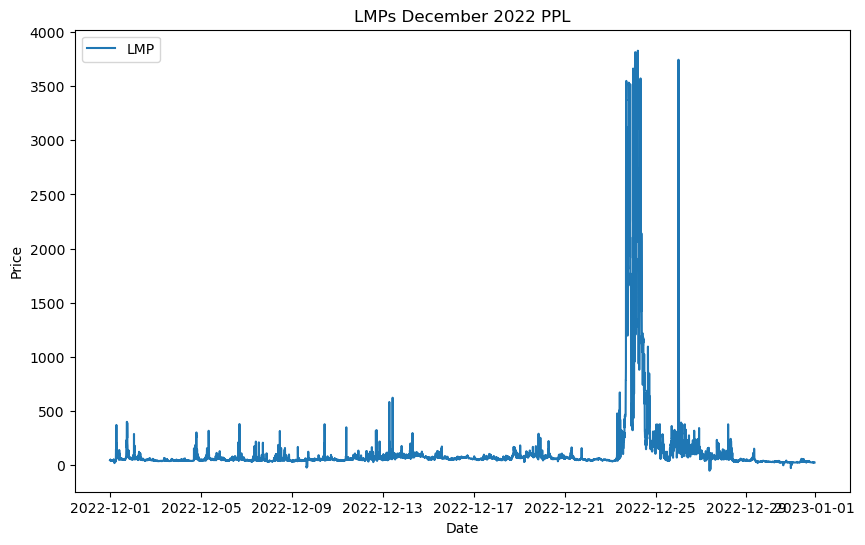

In [12]:
gf.line_single(lmp_ppl_df,1)

We can see clearly that during Winter Storm Elliot, especially on December 23-25, the LMP increases substantially. Poweroutage.com states that the storm started 12/23 and was recovered until 12/27. Let's take a closer look:

In [15]:
storm_lmp_df = lmp_ppl_df[(lmp_ppl_df["Time"] >= "2022-12-23")& (lmp_ppl_df["Time"] <= "2022-12-27")]

Enter x-axis colname: Time
Enter colname: LMP
Enter title: PPL LMPs During Winter Storm Elliott
Enter y-axis label: Price
Enter x-axis label: Date


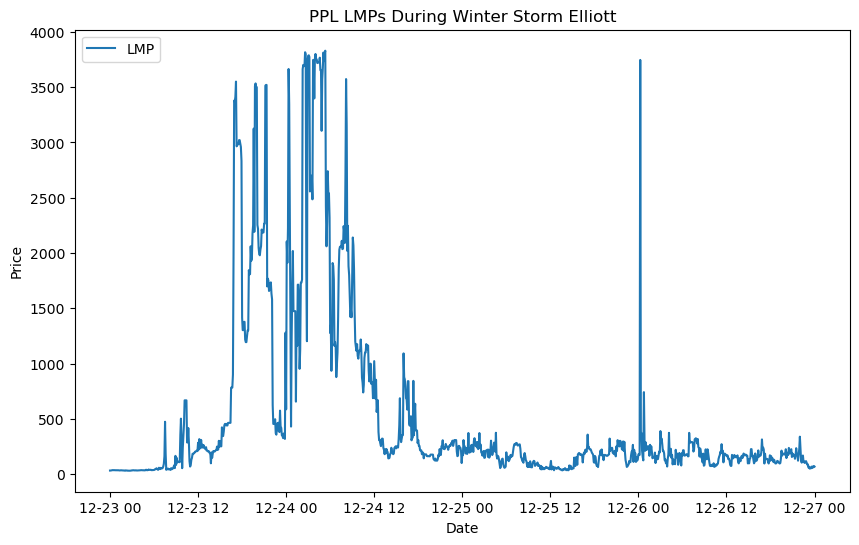

In [16]:
gf.line_single(storm_lmp_df,1)

## Congestion and Loss impact on LMPs in PPL December 2022

First, we'll plot just the congestion and loss:

Enter x-axis colname: Time
Enter colname: Congestion
Enter colname: Loss
Enter title: Congestion and Loss PPL December 2022
Enter y-axis label: Price
Enter x-axis label: Date


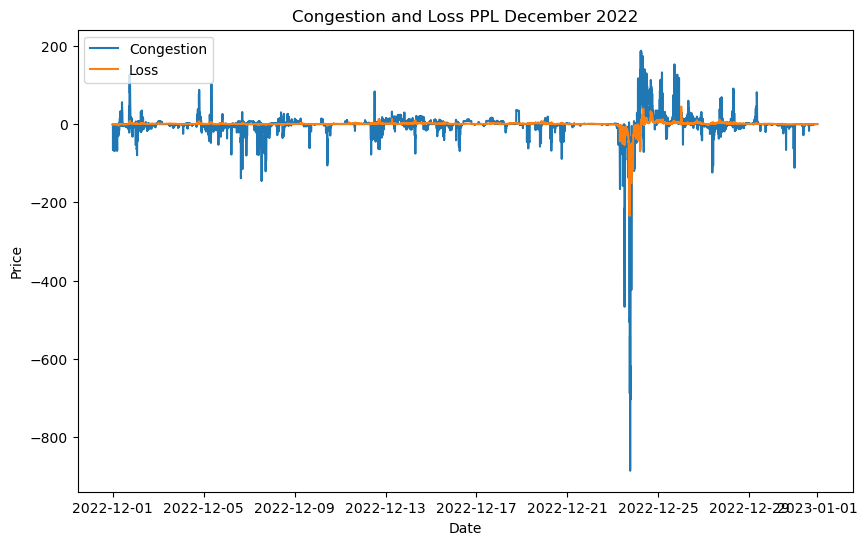

In [17]:
gf.line_single(lmp_ppl_df,2)

It's hard to make super meaningful observations but here are two:

1. it appears that congestion is typically more volatile than loss. This makes sense because loss referes to the component of the value lost in transmission from production to consumption.
2. Both increase substantially during the winter storm, and much more than in ISONE.

Now, congestion and loss during the storm to get a closer look:

Enter x-axis colname: Time
Enter colname: Congestion
Enter colname: Loss
Enter title: Congestion and Loss PPL During Winter Storm Elliott
Enter y-axis label: Price
Enter x-axis label: Date


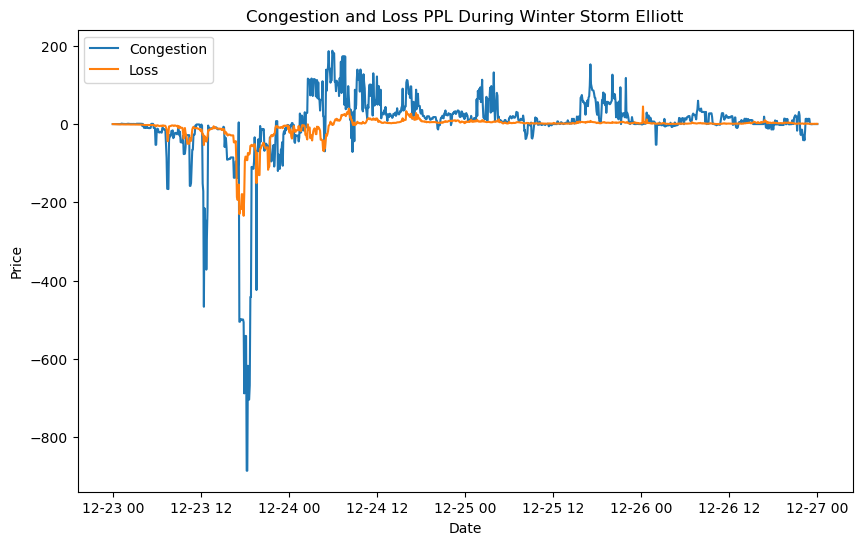

In [18]:
gf.line_single(storm_lmp_df,2)

Why does congestion become positive after the storm?

When there's more congestion and loss, the price of energy is driven up. Little congestion and loss closes the gap between the energy price and the LMP. It is evident that the cost of power was significantly driven up during the winter storm and congestion and loss became a more sizeable portion of that price during this period.

## Clean up fuel mix df and create load column

Since there's a lot of missing load data from PJM from December 2022, we can simulate the load data from totaling the kw in the fuel mix dataset.

In [21]:
mix_df["Load"] = mix_df.sum(axis=1)

/var/folders/fb/lsg_5xw57mz9vhkmk6dvkfkw0000gn/T/ipykernel_24086/3223253513.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mix_df["Load"] = mix_df.sum(axis=1)


In [22]:
mix_df.head()

,Time,Coal,Gas,Hydro,Multiple Fuels,Nuclear,Oil,Other,Other Renewables,Solar,Storage,Wind,Load
0,2022-12-01 00:00:00-05:00,16747.0,32673.0,856.0,3.0,32974.0,95.0,47.0,738.0,15.0,0.0,7382.0,91530.0
1,2022-12-01 01:00:00-05:00,16855.0,31870.0,871.0,3.0,33009.0,97.0,49.0,731.0,15.0,0.0,6920.0,90420.0
2,2022-12-01 02:00:00-05:00,16667.0,32078.0,794.0,3.0,32996.0,96.0,48.0,738.0,15.0,0.0,6713.0,90148.0
3,2022-12-01 03:00:00-05:00,16352.0,32532.0,764.0,3.0,32999.0,98.0,47.0,726.0,15.0,0.0,6016.0,89552.0
4,2022-12-01 04:00:00-05:00,16657.0,33969.0,1067.0,3.0,32988.0,96.0,50.0,743.0,15.0,0.0,5287.0,90875.0


## Plotting PPL Load for December 2022

Enter x-axis colname: Time
Enter colname: Load
Enter title: PPL Load December 2022
Enter y-axis label: kw
Enter x-axis label: Date


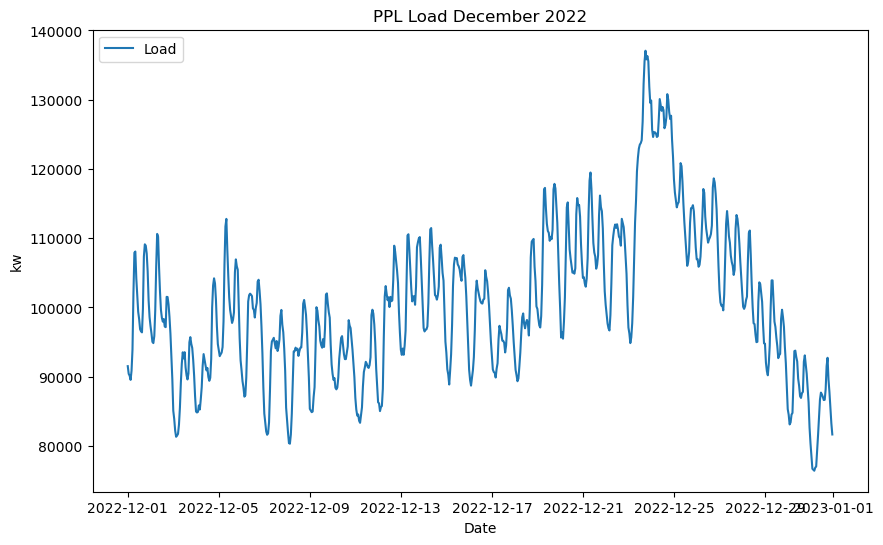

In [24]:
gf.line_single(mix_df,1)

Looking just at the storm dates:

In [26]:
storm_load_df = mix_df[(mix_df["Time"] >= "2022-12-23")& (mix_df["Time"] <= "2022-12-27")]

Enter x-axis colname: Time
Enter colname: Load
Enter title: PPL Load During Winter Storm Elliott
Enter y-axis label: kw
Enter x-axis label: Date


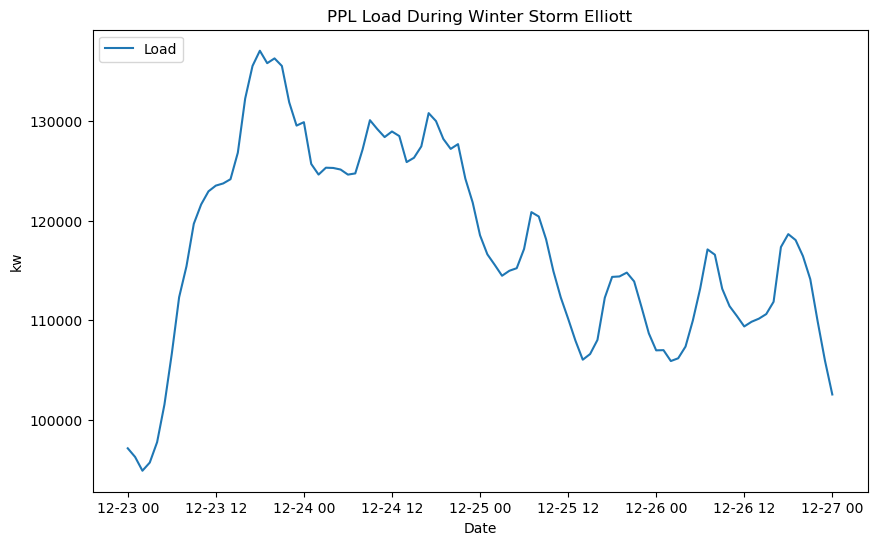

In [27]:
gf.line_single(storm_load_df,1)

In [28]:
hourly_load_df = gf.hourly_data(mix_df)

Enter x-axis colname: Hour
Enter colname: Load
Enter title: Hourly Load PPL December 2022
Enter y-axis label: kw
Enter x-axis label: Hour


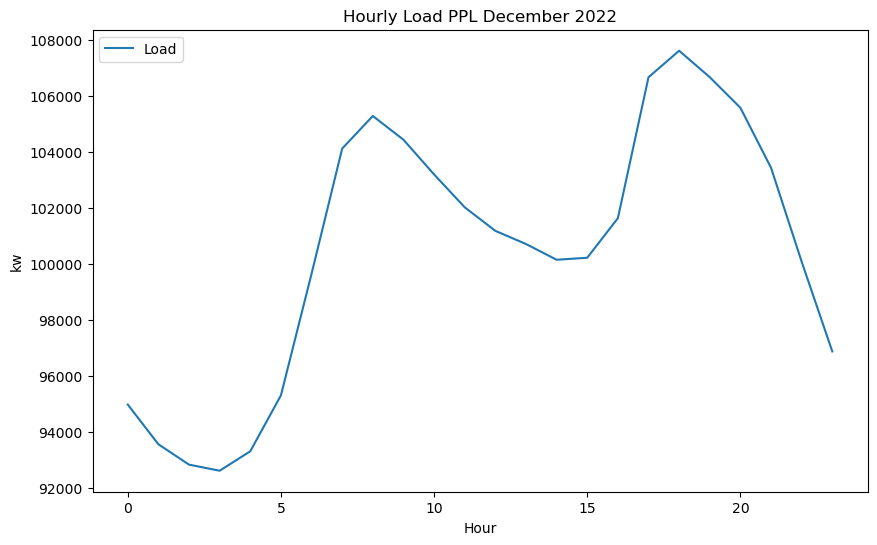

In [29]:
gf.line_single(hourly_load_df,1)

## Plotting Fuel Mix

In [32]:
mix_df = mix_df.drop(columns='Hour')

In [33]:
mix_df["total"] = mix_df.sum(axis=1)

/var/folders/fb/lsg_5xw57mz9vhkmk6dvkfkw0000gn/T/ipykernel_24086/530574969.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mix_df["total"] = mix_df.sum(axis=1)


In [37]:
cols = mix_df.columns[1:-1]
for c in cols:
    mix_df[c+'%'] = mix_df[c] / mix_df["Load"]

In [40]:
mix_df.columns

Index(['Time', 'Coal', 'Gas', 'Hydro', 'Multiple Fuels', 'Nuclear', 'Oil',
       'Other', 'Other Renewables', 'Solar', 'Storage', 'Wind', 'Load',
       'Coal%', 'Gas%', 'Hydro%', 'Multiple Fuels%', 'Nuclear%', 'Oil%',
       'Other%', 'Other Renewables%', 'Solar%', 'Storage%', 'Wind%'],
      dtype='object')

In [42]:
gf.basics(mix_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype                                 
---  ------             --------------  -----                                 
 0   Time               744 non-null    datetime64[ns, pytz.FixedOffset(-300)]
 1   Coal               744 non-null    float64                               
 2   Gas                744 non-null    float64                               
 3   Hydro              744 non-null    float64                               
 4   Multiple Fuels     744 non-null    float64                               
 5   Nuclear            744 non-null    float64                               
 6   Oil                744 non-null    float64                               
 7   Other              744 non-null    float64                               
 8   Other Renewables   744 non-null    float64                               
 9   Solar              74

,Time,Coal,Gas,Hydro,Multiple Fuels,Nuclear,Oil,Other,Other Renewables,Solar,...,Gas%,Hydro%,Multiple Fuels%,Nuclear%,Oil%,Other%,Other Renewables%,Solar%,Storage%,Wind%
0,2022-12-01 00:00:00-05:00,16747.0,32673.0,856.0,3.0,32974.0,95.0,47.0,738.0,15.0,...,0.356965,0.009352,0.000033,0.360253,0.001038,0.000513,0.008063,0.000164,0.0,0.080651
1,2022-12-01 01:00:00-05:00,16855.0,31870.0,871.0,3.0,33009.0,97.0,49.0,731.0,15.0,...,0.352466,0.009633,0.000033,0.365063,0.001073,0.000542,0.008084,0.000166,0.0,0.076532
2,2022-12-01 02:00:00-05:00,16667.0,32078.0,794.0,3.0,32996.0,96.0,48.0,738.0,15.0,...,0.355837,0.008808,0.000033,0.366020,0.001065,0.000532,0.008187,0.000166,0.0,0.074466
3,2022-12-01 03:00:00-05:00,16352.0,32532.0,764.0,3.0,32999.0,98.0,47.0,726.0,15.0,...,0.363275,0.008531,0.000034,0.368490,0.001094,0.000525,0.008107,0.000168,0.0,0.067179
4,2022-12-01 04:00:00-05:00,16657.0,33969.0,1067.0,3.0,32988.0,96.0,50.0,743.0,15.0,...,0.373799,0.011741,0.000033,0.363004,0.001056,0.000550,0.008176,0.000165,0.0,0.058179


Enter x-axis colname: Time
Enter colname: Gas%
Enter colname: Wind%
Enter colname: Hydro%
Enter colname: Nuclear%
Enter colname: Oil%
Enter title: PPL December 2022 Fuel Mix
Enter y-axis label: Percentage of Mix
Enter x-axis label: Date


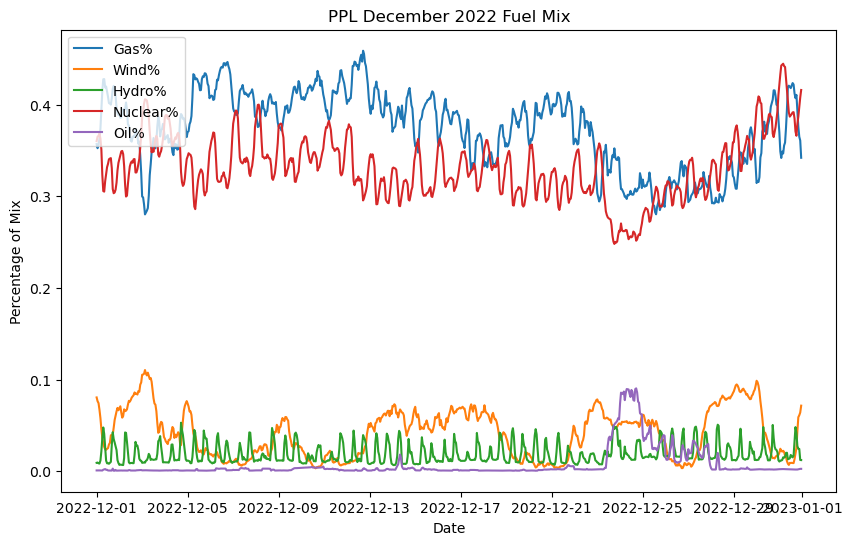

In [44]:
# 'Coal%', 'Gas%', 'Hydro%', 'Multiple Fuels%', 'Nuclear%', 'Oil%',
#'Other%', 'Other Renewables%', 'Solar%', 'Storage%', 'Wind%'
gf.line_single(mix_df,5)

Natural gas production did not decrease as much as it did in ISONE during Winter Storm Elliott. However, it did decrease around 10% of the total fuel mix. This generation was again, conincides with a temporary increase in oil. Wind, hydro, and nuclear provide steady generation throughout the month.

## Average Daily Fuel Mix PPL December 2022

In [47]:
#This dataframe is labeled as load but contains the aggreagated hourly fuel mix data.
hourly_load_df

,Coal,Gas,Hydro,Multiple Fuels,Nuclear,Oil,Other,Other Renewables,Solar,Storage,Wind,Load,Hour
0,20913.258065,33763.677419,1113.419355,123.612903,32919.580645,723.000000,141.419355,641.258065,6.193548,0.0,4639.419355,94984.838710,0.0
1,20452.774194,33007.935484,1021.548387,115.387097,32945.903226,703.580645,144.290323,643.935484,6.129032,0.0,4526.419355,93567.903226,1.0
2,20193.709677,32786.774194,994.935484,130.870968,32925.645161,707.806452,138.967742,638.483871,6.096774,0.0,4317.870968,92841.161290,2.0
3,20104.806452,32711.612903,1009.870968,150.838710,32933.838710,704.774194,138.129032,633.903226,6.096774,0.0,4230.516129,92624.387097,3.0
4,20175.612903,33254.129032,1111.064516,147.258065,32946.193548,777.225806,140.129032,638.290323,6.096774,0.0,4122.000000,93318.000000,4.0
5,20407.741935,34715.612903,1512.677419,164.838710,32959.161290,802.064516,119.967742,636.935484,6.096774,0.0,3987.838710,95312.935484,5.0
6,20914.612903,37004.645161,2687.387097,372.903226,32970.032258,909.870968,128.483871,641.129032,6.096774,0.0,4013.096774,99648.258065,6.0
7,21739.935484,39399.193548,3653.903226,405.870968,32971.032258,1088.000000,129.419355,636.516129,16.354839,0.0,4073.903226,104114.129032,7.0
8,22199.580645,39833.419355,3244.935484,428.129032,32978.483871,1096.451613,183.516129,636.774194,554.677419,0.0,4121.161290,105277.129032,8.0
9,22232.806452,39357.548387,2189.483871,430.193548,32974.838710,889.935484,245.451613,641.483871,1269.741935,0.0,4199.322581,104430.806452,9.0


Enter x-axis colname: Time
***Invalid colname***
Enter x-axis colname: Hour
Enter colname: Gas%
***Invalid colname***
Enter colname: Gas
Enter colname: Wind
Enter colname: Solar
Enter colname: Nuclear
Enter colname: Hydro
Enter colname: Oil
Enter title: Average Hourly Fuel Mix PPL December 2022
Enter y-axis label: kw
Enter x-axis label: Date


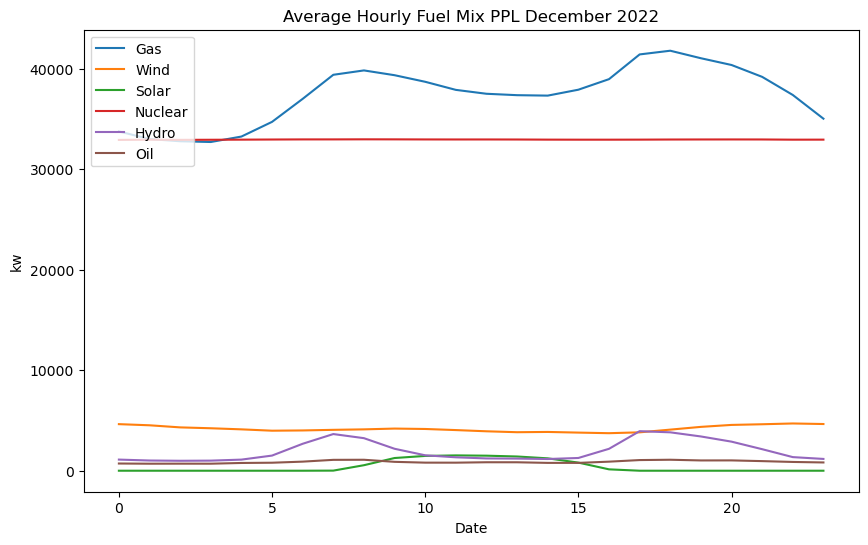

In [48]:
gf.line_single(hourly_load_df,6)

Natural gas production increases throughout the day and peaks just after dinnertime. This corresponds with peak load. Generation can be increased quickly on these natural gas to satisfy peak load. Besides hydro, which follows a similar load curve to natural gas, and solar, which produces only during daytime hours, the rest of the sources provide consistent generation.

In [65]:
hourly_mix_pct_df = gf.hourly_data(mix_df)

Enter x-axis colname: Time
***Invalid colname***
Enter x-axis colname: Hour
Enter colname: Solar%
Enter colname: Wind%
Enter colname: Hydro%
Enter colname: Nuclear%
Enter colname: Gas%
Enter colname: Oil%
Enter title: Average Hourly Fuel Mix PPL December 2022
Enter y-axis label: Percentage of Generation
Enter x-axis label: Date


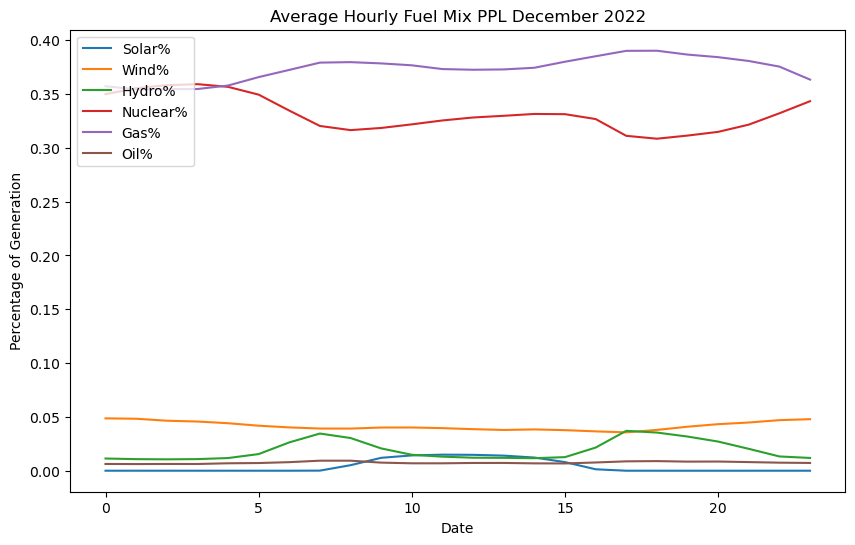

In [67]:
gf.line_single(hourly_mix_pct_df,6)

Nuclear and natural gas generation display an inverse relationship.

## Average Daily Fuel Mix Stacked Bar Chart by Total Generation

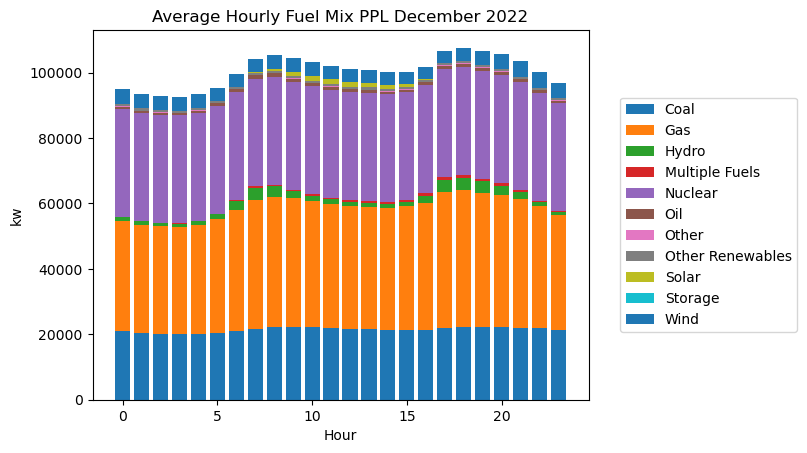

In [49]:
# Create stacked bar chart
fig, ax = plt.subplots()

for col in hourly_load_df.columns[:11]:
    ax.bar(hourly_load_df.index, hourly_load_df[col], 
           label=col, bottom=hourly_load_df[hourly_load_df.columns[:list(hourly_load_df.columns).index(col)]].sum(axis=1))

# Add labels and legend
ax.set_xlabel('Hour')
ax.set_ylabel('kw')
ax.set_title('Average Hourly Fuel Mix PPL December 2022')
plt.legend(bbox_to_anchor=(1.05, .5), loc='center left')

# Show the chart
plt.show()

## Conclusions

**Coding, Datasets**

1. Getting the data hourly is important when comparing different datasets
2. Since the fuel mix is for the entire ISO and not by zone, we don't get a perfect comparison between the LMPs and demand.

**Data**

1. Daily demand peaks around 5 pm
2. The LMP increases at peak demand
3. The LMP skyrocketed during Winter Storm Elliot, peaking at over 3500/kwh on December 24
4. Natural gas consumption not only increases at peak demand, but increases as a percentage of overall generation at peak demand. This means natural gas production is needed to satisfy peak demanda. This is likely because it can be ramped up quickly. 
5. Average natural gas consumption by hour as a percentage of total consumption by hour functions inversely propotionately to that of nuclear.
6. Natural gas production could not withstand the winter storm and was replaced by oil during that time.